In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
from collections import Counter


In [9]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('../data/raw/korean_sentiment_dataset.csv')

# 데이터 기본 정보 출력
print("📊 데이터 기본 정보")
print(f"데이터 크기: {df.shape}")
print(f"컬럼명: {list(df.columns)}")
print("\n" + "="*50)
df.head()

📊 데이터 기본 정보
데이터 크기: (3000, 2)
컬럼명: ['text', 'label']



,text,label
0,그냥 사람들 앞에 서는 게 너무 무서워요 괜히입니다.,1
1,솔직히 계속 가슴이 답답하고 조마조마해요입니다.,1
2,작은 일에도 깜짝깜짝 놀라요 정말했어요.,1
3,사실은 하루하루가 너무 힘들어요입니다.,0
4,이상하게도 좋아하는 노래를 들으니 기분이 좋아졌어요 별 이유 없이싶어요.,2


라벨별 개수 : 
우울: 1000개 (33.33%)
불안: 1000개 (33.33%)
정상: 1000개 (33.33%)

 전체 데이터: 3000개



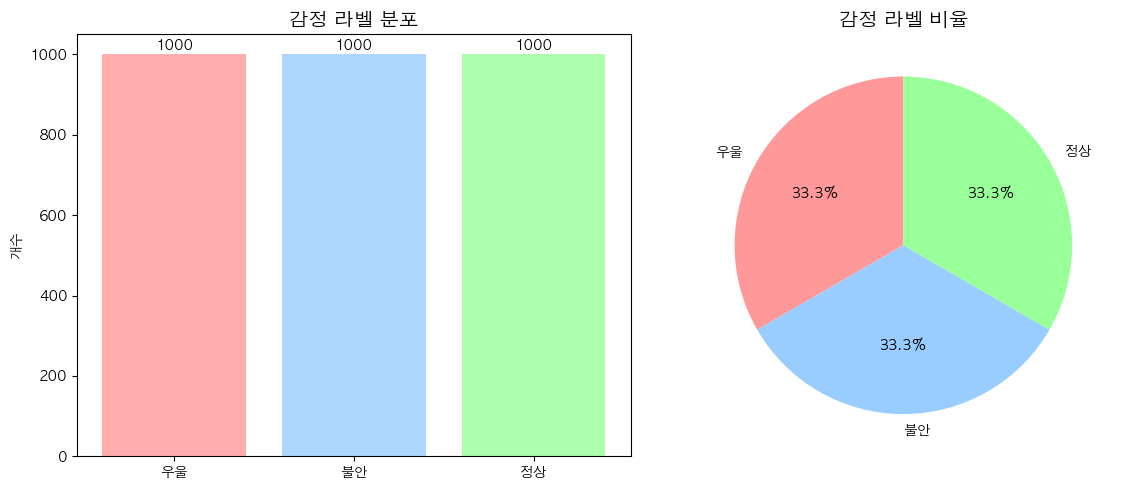


📊 데이터 균형성 분석:
최대/최소 비율: 1.00 (1.5 이하면 균형적)
✅ 비교적 균형잡힌 데이터입니다.


In [10]:
# 감정 라벨 분포 시각화
label_counts = df['label'].value_counts().sort_index()
print("라벨별 개수 : ")
for label, count in label_counts.items():
    emotion = ['우울', '불안', '정상'][label]
    percentage = (count / len(df)) * 100
    print(f"{emotion}: {count}개 ({percentage:.2f}%)")

print(f"\n 전체 데이터: {len(df)}개")
print("\n" + "="*50)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

# 라벨별 개수 막대 그래프
labels = ['우울', '불안', '정상']
counts = [label_counts[i] for i in range(3)]
colors = ['#FF9999', '#99CCFF', '#99FF99']

ax1.bar(labels, counts, color=colors, alpha=0.8)
ax1.set_title('감정 라벨 분포', fontsize=14, fontweight='bold')
ax1.set_ylabel('개수')
for i, count in enumerate(counts):
    ax1.text(i, count + 10, str(count), ha='center', fontweight='bold')

# 파이 차트
ax2.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('감정 라벨 비율', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 데이터 균형성 체크
print("\n📊 데이터 균형성 분석:")
max_count = max(counts)
min_count = min(counts)
imbalance_ratio = max_count / min_count
print(f"최대/최소 비율: {imbalance_ratio:.2f} (1.5 이하면 균형적)")
if imbalance_ratio > 2:
    print("⚠️  데이터 불균형이 심합니다. 추후 샘플링 필요할 수 있습니다.")
else:
    print("✅ 비교적 균형잡힌 데이터입니다.")

In [11]:
# 간단한 데이터 샘플 확인
print("🔍 각 감정별 샘플 문장:")
print("="*50)
for label in range(3):
    emotion = ['우울', '불안', '정상'][label]
    samples = df[df['label'] == label]['text'].head(3).tolist()
    print(f"\n{emotion} 샘플:")
    for i, text in enumerate(samples, 1):
        print(f"  {i}. {text}")

🔍 각 감정별 샘플 문장:

우울 샘플:
  1. 사실은 하루하루가 너무 힘들어요입니다.
  2. 가끔은 마음이 자꾸 가라앉고 어두워요 너무였어요.
  3. 어느 순간부터 아무 이유 없이 눈물이 나요 너무였어요.

불안 샘플:
  1. 그냥 사람들 앞에 서는 게 너무 무서워요 괜히입니다.
  2. 솔직히 계속 가슴이 답답하고 조마조마해요입니다.
  3. 작은 일에도 깜짝깜짝 놀라요 정말했어요.

정상 샘플:
  1. 이상하게도 좋아하는 노래를 들으니 기분이 좋아졌어요 별 이유 없이싶어요.
  2. 솔직히 커피 한 잔 마시면서 여유를 즐겼어요하네요.
  3. 솔직히 밥이 너무 맛있게 느껴졌어요 정말요.


In [12]:
# 📊 데이터 증강 - 우울 관련 문장 추가
print("🔧 데이터 증강 시작...")
print("="*50)

# 기존 데이터 확인
print(f"기존 데이터 크기: {df.shape}")
print(f"우울 라벨 개수: {len(df[df['label'] == 0])}")

# 우울 관련 추가 데이터 (다양한 표현 방식 포함)
depression_data = [
    # 직접적인 우울 표현
    ("너무 우울해요", 0),
    ("우울하고 슬퍼요", 0),
    ("우울감이 심해요", 0),
    ("우울한 기분이에요", 0),
    ("오늘도 우울해요", 0),
    ("계속 우울한 상태예요", 0),
    ("우울증이 있는 것 같아요", 0),
    ("우울한 마음이 들어요", 0),
    ("매일 우울해요", 0),
    ("우울해서 힘들어요", 0),
    
    # 간접적인 우울 표현 (기존 패턴과 연결)
    ("우울하고 의욕이 없어요", 0),
    ("우울해서 아무것도 하기 싫어요", 0),
    ("우울하고 잠이 안 와요", 0),
    ("우울해서 혼자 있고 싶어요", 0),
    ("우울하고 사는 게 재미없어요", 0),
    ("우울해서 사람들이랑 얘기하고 싶지 않아요", 0),
    ("우울하고 슬퍼서 눈물이 나요", 0),
    ("우울감 때문에 힘들어요", 0),
    ("우울한 감정이 계속돼요", 0),
    ("우울해서 무기력해요", 0),
]

# 데이터프레임 생성
new_depression_df = pd.DataFrame(depression_data, columns=['text', 'label'])

# 기존 데이터와 합치기
enhanced_df = pd.concat([df, new_depression_df], ignore_index=True)

print(f"\n✅ 증강된 데이터 크기: {enhanced_df.shape}")
print(f"우울 라벨 개수: {len(enhanced_df[enhanced_df['label'] == 0])}")
print(f"추가된 문장 수: {len(new_depression_df)}")

# 새로운 균형성 확인
new_label_counts = enhanced_df['label'].value_counts().sort_index()
print(f"\n📊 증강 후 라벨 분포:")
for label, count in new_label_counts.items():
    emotion = ['우울', '불안', '정상'][label]
    percentage = (count / len(enhanced_df)) * 100
    print(f"{emotion}: {count}개 ({percentage:.2f}%)")

# 증강된 데이터 저장
enhanced_df.to_csv('../data/raw/enhanced_korean_sentiment_dataset.csv', index=False, encoding='utf-8')
print(f"\n💾 증강된 데이터 저장 완료: enhanced_korean_sentiment_dataset.csv")
print("이제 이 데이터로 모델을 재훈련해야 합니다!")

🔧 데이터 증강 시작...
기존 데이터 크기: (3000, 2)
우울 라벨 개수: 1000

✅ 증강된 데이터 크기: (3020, 2)
우울 라벨 개수: 1020
추가된 문장 수: 20

📊 증강 후 라벨 분포:
우울: 1020개 (33.77%)
불안: 1000개 (33.11%)
정상: 1000개 (33.11%)

💾 증강된 데이터 저장 완료: enhanced_korean_sentiment_dataset.csv
이제 이 데이터로 모델을 재훈련해야 합니다!
